In [2]:
%%capture
!pip install geemap earthengine-api
!pip install rasterio matplotlib numpy

In [6]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [7]:
try:
    ee.Authenticate()
    ee.Initialize(project='ee-sandorburian')
    print("✓ Earth Engine initialized successfully")
except Exception as e:
    print(f"Error: {e}")
    print("Run: ee.Authenticate() first")

✓ Earth Engine initialized successfully


In [30]:
# Example regions
## Greece
greece = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017") \
           .filter(ee.Filter.eq('country_na', 'Greece'))
greece_boundary = greece.geometry()

## Athens
athens_region = ee.Geometry.Rectangle([23.5, 37.8, 24.1, 38.2])

## Demo
test_region   = ee.Geometry.Rectangle([40.7, 26.4, 24.1, 38.2])

## Bushfire in 2023
burn_test_region = ee.Geometry.Rectangle([
    25.419968028200316, 40.79514759494151,  # xmin, ymin (SW corner)
    26.305033189080742, 41.2277677156888    # xmax, ymax (NE corner)
])

In [11]:
burn_region_fire_2023 = ee.Geometry.Rectangle([
    25.419968028200316, 40.79514759494151,  # xmin, ymin (SW corner)
    26.305033189080742, 41.2277677156888    # xmax, ymax (NE corner)
])

burn_region_fire_2011 = ee.Geometry.Rectangle([
    40.9439, 26.0201,  # xmin, ymin (SW corner)
    41.0649, 26.2340    # xmax, ymax (NE corner)
])

burn_region_fire_2011

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              40.9439,
              26.234
            ],
            [
              40.9439,
              26.0201
            ],
            [
              41.0649,
              26.0201
            ],
            [
              41.0649,
              26.234
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [25]:
def Sentinel2_Satellite_Imagery(area_of_interest=burn_region_fire_2023, start_date = '2023-07-13', end_date = '2023-08-13', cloud_threshold = 10):
  '''
  Get Sentinel-2 Surface Reflectance collection
  arguments:
  - area_of_interest: ee.Geometry
  - start_date: yyyy-mm-dd
  - end_date: yyyy-mm-dd
  - cloud_threshold: percentage of cloud on the image, value from 0 to 100

  return: Sentinel-2 Surface Reflectance collection or if there is no image found return None
  '''
  # Get Sentinel-2 Surface Reflectance collection
  sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                .filterDate(start_date, end_date) \
                .filterBounds(area_of_interest) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_threshold))

  # Check how many images we found
  image_count = sentinel2.size().getInfo()
  print(f"Found {image_count} Sentinel-2 images for the specified period")

  # return the images
  if image_count == 0:
      print("⚠️  No images found. Try expanding date range or increasing cloud threshold.")
      return None
  else:
    return sentinel2

# Test the function with default values
sentinel2 = Sentinel2_Satellite_Imagery()

Found 15 Sentinel-2 images for the specified period


In [26]:
def Landsat_LE7_C2_T1(area_of_interest=burn_region_fire_2011, start_date = '2011-08-24', end_date = '2011-10-24'):
  '''
  Get USGS Landsat 7 Level 2, Collection 2, Tier 1 Surface Reflectance collection
  arguments:
  - area_of_interest: ee.Geometry
  - start_date: yyyy-mm-dd
  - end_date: yyyy-mm-dd

  return: Landsat Surface Reflectance collection or if there is no image found return None
  '''
  # Get Landsat Surface Reflectance collection
  landsat = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
                .filterDate(start_date, end_date) \
                .filterBounds(area_of_interest)

  # Check how many images we found
  image_count = landsat.size().getInfo()
  print(f"Found {image_count} USGS Landsat 7 Level 2, Collection 2, Tier 1 images for the specified period")

  if image_count == 0:
      print("⚠️  No images found. Try expanding date range or increasing cloud threshold.")
      return None
  else:
    return landsat

# Test the function with default values
landsat = Landsat_LE7_C2_T1()

Found 6 USGS Landsat 7 Level 2, Collection 2, Tier 1 images for the specified period


In [75]:
def calculate_ndvi_on_Sentinel2(image):
    """
    Calculate NDVI for a Sentinel-2 image
    B4 = Red band, B8 = NIR band
    """
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

def calculate_median_ndvi_on_Sentinel2():
    """
    Calculate the median NDVI for a collection of Sentinel-2 images
    """
    try:
      # Apply NDVI calculation to all images
      ndvi_collection = sentinel2.map(calculate_ndvi_on_Sentinel2)

      # Create median composite to reduce cloud effects and seasonal variation
      median_ndvi = ndvi_collection.select('NDVI').median().clip(burn_region_fire_2023)

      print("✓ NDVI calculated successfully")
      return median_ndvi
    except Exception as e:
      print(f"⚠️ An error occurred while calculating NDVI: {e}")
      return None

# Calculate median NDVI
median_ndvi_sentinel2 = calculate_median_ndvi_on_Sentinel2()

✓ NDVI calculated successfully


In [74]:
def show_interactive_map_with_ndvi_layer(median_ndvi, interested_area = burn_region_fire_2023):
  '''
  Display an interactive map with NDVI layer
  arguments:
  - median_ndvi: ee.Image
  - interested_area: ee.Geometry
  '''

  # Define NDVI visualization parameters
  ndvi_params = {
      'min': -0.2,
      'max': 0.8,
      'palette': [
          '#d73027',  # Red (low NDVI - bare soil/water)
          '#f46d43',  # Orange
          '#fdae61',  # Light orange
          '#fee08b',  # Yellow
          '#e6f598',  # Light green
          '#abdda4',  # Green
          '#66c2a5',  # Dark green
          '#3288bd'   # Blue-green (high NDVI - dense vegetation)
      ]
  }

  # Add NDVI layer to map
  Map.addLayer(median_ndvi, ndvi_params, 'NDVI Layer')

  # Add Greece boundary (optional)
  Map.addLayer(greece_boundary, {'color': 'red', 'width': 2}, 'Greece Boundary', False)

  # Center map on area of interest
  Map.centerObject(interested_area, 8)

  # Display map
  return Map


# Demo usage of this visualisation function
map = show_interactive_map_with_ndvi_layer(median_ndvi_sentinel2)
map

Map(bottom=393208.0, center=[41.012067138890096, 25.862500608640715], controls=(WidgetControl(options=['positi…

In [113]:
def NDVI_interretation(mean_ndvi):
  #mean_ndvi = ndvi_stats['NDVI_mean']
  if mean_ndvi > 0.6:
      interpretation = "Dense, healthy vegetation"
  elif mean_ndvi > 0.3:
      interpretation = "Moderate vegetation cover"
  elif mean_ndvi > 0:
      interpretation = "Sparse vegetation"
  else:
      interpretation = "Predominantly non-vegetated areas"
  print(f"🌱 Interpretation: {interpretation}")
  return interpretation

#NDVI_interretation(ndvi_stats['NDVI_mean'])

📊 NDVI Statistics for the area:
min -0.35740536
max 0.9343518
mean 0.5131947
std 0.26811945
shape (477224,)
🌱 Interpretation: Moderate vegetation cover


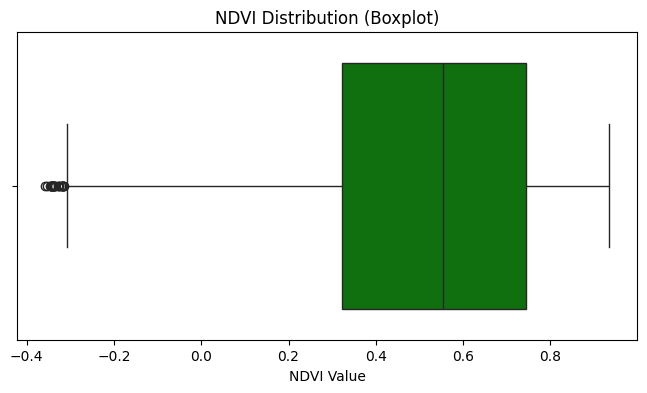

In [114]:
import seaborn as sns

# Extract NDVI pixel values as a NumPy array
region = burn_region_fire_2023.getInfo()['coordinates']
ndvi_array = geemap.ee_to_numpy(median_ndvi_sentinel2, region=burn_region_fire_2023, bands=['NDVI'], scale=100) #scale = 30 is the minimum

# Flatten the array and remove NaN values
ndvi_flat = ndvi_array.flatten()
ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]

print("📊 NDVI Statistics for the area:")
print("min", ndvi_flat.min())
print("max", ndvi_flat.max())
print("mean", ndvi_flat.mean())
print("std", ndvi_flat.std())
print("shape", ndvi_flat.shape)
NDVI_interretation(ndvi_flat.mean())

# Plot Seaborn boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=ndvi_flat, color='green')
plt.title('NDVI Distribution (Boxplot)')
plt.xlabel('NDVI Value')
plt.show()

In [93]:
ndvi_array

array([[[ 0.8141994 ],
        [ 0.87271917],
        [ 0.8814499 ],
        ...,
        [ 0.67910486],
        [ 0.4474221 ],
        [ 0.68476075]],

       [[ 0.7688525 ],
        [ 0.87250996],
        [ 0.890058  ],
        ...,
        [ 0.54475045],
        [ 0.5043472 ],
        [ 0.412095  ]],

       [[ 0.76750624],
        [ 0.84678847],
        [ 0.78604895],
        ...,
        [ 0.29375437],
        [ 0.52979976],
        [ 0.41084537]],

       ...,

       [[-0.02060222],
        [-0.01724138],
        [-0.01984733],
        ...,
        [ 0.76228154],
        [ 0.81345344],
        [ 0.805341  ]],

       [[-0.01967213],
        [-0.02431611],
        [-0.00917431],
        ...,
        [ 0.7816444 ],
        [ 0.7941218 ],
        [ 0.78427196]],

       [[-0.01551189],
        [-0.01577287],
        [-0.0184182 ],
        ...,
        [ 0.78166515],
        [ 0.762056  ],
        [ 0.7822288 ]]], dtype=float32)

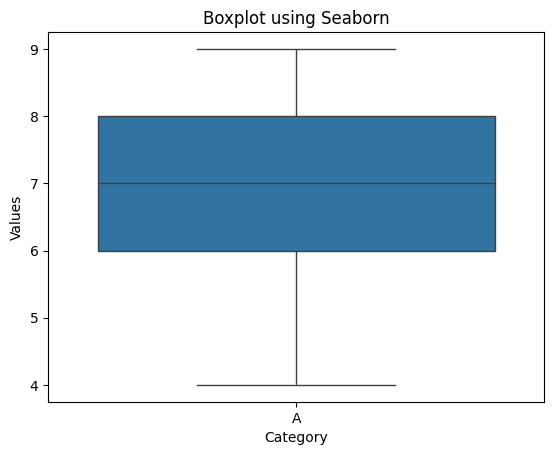

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = pd.DataFrame({
    'Category': ['A', 'A', 'A','A','A', 'A','A', 'A', 'A'],
    'Values': [7, 8, 6, 5, 4, 6, 8, 9, 7]
})

# Create a boxplot
sns.boxplot(x='Category', y='Values', data=data)

# Show the plot
plt.title("Boxplot using Seaborn")
plt.show()
